In [76]:
#### Primeiro passo, importar as bibliotecas que seraão ultilizadas
import pandas as pd  #### Leitura e processamento de dados no python, tipo o Excel do Python
import datetime as dt ########### Biblioteca com funcçoes que ajudam com datas
import numpy as np    ####### Biblioteca com funçoes Matematicas
from tqdm.notebook import trange ############ Cria barra de carregamento para poder acompanhar o processor
import matplotlib.pyplot as plt ########## Biblioteca com Funçoes para plotagem de graficos
from sklearn.preprocessing import MinMaxScaler ########## Funçoes para normalizar os dados de entrada da rede
############## TensorFlow 
from tensorflow.keras.layers import Dense,Input,GRU,LSTM ########### Camadas que ultilizaremos na rede
from tensorflow.keras import Sequential ####### Tipo de modelo que usaremos
from tensorflow.keras.callbacks import ReduceLROnPlateau #### Função para Reduzir a taxa de aprendizado (LR)

In [2]:
######## Primiro passo irmos ler os dados que estão no GITHUB que são originados do INMET
data = pd.read_csv('https://raw.githubusercontent.com/otaviomf123/Cusor-ML-para-Meteorologia-2020-04-20/master/INMET_A801.csv', 
                 error_bad_lines=False,index_col=0)

In [77]:
######## Podemos visulaizar como ods dados estão organizados
data.head()

,Temperatura,P_Orvalho,Umidade_Relativa,Vento,Precipitacao,Pressao,Dir_vento,Radiacao,date
2013-02-19 00:00:00,24.6,20.8,79.0,1.5,0.0,1009.9,135.0,-3.470,2013-02-19 00:00:00
2013-02-19 01:00:00,24.3,20.8,81.0,1.4,0.0,1010.5,132.0,-3.111,2013-02-19 01:00:00
2013-02-19 02:00:00,24.0,20.6,81.0,2.1,0.0,1010.4,136.0,-3.038,2013-02-19 02:00:00
2013-02-19 03:00:00,23.3,20.5,84.0,3.1,0.0,1009.8,135.0,-3.200,2013-02-19 03:00:00
2013-02-19 04:00:00,23.1,20.1,83.0,2.0,0.0,1008.9,124.0,-3.328,2013-02-19 04:00:00


In [3]:
##### Função que ultilizaremos para pegar os dados apenas no intevalo de tempo selecionado
def pegar_dados_no_intervalo(df,start_date,end_date):
    df['date'] = pd.to_datetime(df.index)  
    #greater than the start date and smaller than the end date
    mask = (df['date'] >= start_date) & (df['date'] < end_date)
    if len(df.loc[mask])>=23:
        return df.loc[mask],True
    else:
        return False,False

In [78]:
######## Função de normalização Tanh, e desnormalização, para mais informação entre em :
## https://alfurka.github.io/2018-11-10-preprocessing-for-nn/ 
def tanh_norm(x,mean,std):
    return 0.5*np.tanh(0.01*((x-mean)/std))
def unorm_tanh(x,mean,std):
    return ((np.arctanh(x/0.5)/0.01)*std)+mean

In [5]:
############# Aque faremos o loop que organizara os dados em 'Pacotinhos' contendo os ultimos 6 
## dias e todas as variaveis que ela ira 'enchegar' comop os dados são horarios iremos colocar apeas a media 
## o devio padão o minio e o maximo de cada dia, assim de ves termos 24 dados teremos apeas 4 de cada variavel
## ja a chuva nos inporta apensas a soma do valor total.
data_inicial=dt.datetime(2013,2,19) ### Data inical
X=[]
Y=[]
for n in trange(2000): ### Primeiro loop ira passar os proximos 2000 dias variando no tempo ###
    d=data_inicial+dt.timedelta(days=n) ### d = delta tempo iramos passar de dia em dia 
    xii=[]
    for i in range(n-6,n): #### aqui iremos pegar os dados do d -6 dias até chegar no d-1 
        xi=[]
        di=d+dt.timedelta(days=i)
        df=d+dt.timedelta(days=i+1)
        dados_int,c=pegar_dados_no_intervalo(data,di,df)
        if c==True:
            ### C representa se ha dados no dia selecionado existe muitas lacunas de dados 
            xi.append(np.mean(dados_int.Temperatura))
            xi.append(np.std(dados_int.Temperatura))
            xi.append(np.max(dados_int.Temperatura))
            xi.append(np.min(dados_int.Temperatura))
            ##############################
            xi.append(np.std(dados_int.P_Orvalho))
            xi.append(np.max(dados_int.P_Orvalho))
            xi.append(np.min(dados_int.P_Orvalho))
            xi.append(np.min(dados_int.P_Orvalho))
            ###############################
            xi.append(np.std(dados_int.Umidade_Relativa))
            xi.append(np.max(dados_int.Umidade_Relativa))
            xi.append(np.min(dados_int.Umidade_Relativa))
            xi.append(np.min(dados_int.Umidade_Relativa))
            ################################
            xi.append(np.std(dados_int.Vento))
            xi.append(np.max(dados_int.Vento))
            xi.append(np.min(dados_int.Vento))
            xi.append(np.min(dados_int.Vento))
            ################################
            xi.append(np.std(dados_int.Pressao))
            xi.append(np.max(dados_int.Pressao))
            xi.append(np.min(dados_int.Pressao))
            xi.append(np.min(dados_int.Pressao))
            ################################
            xi.append(np.std(dados_int.Dir_vento))
            xi.append(np.max(dados_int.Dir_vento))
            xi.append(np.min(dados_int.Dir_vento))
            xi.append(np.min(dados_int.Dir_vento))
            ################################
            xi.append(np.std(dados_int.Radiacao))
            xi.append(np.max(dados_int.Radiacao))
            xi.append(np.min(dados_int.Radiacao))
            xi.append(np.min(dados_int.Radiacao))
            ##################################
            xi.append(np.sum(dados_int.Precipitacao))
            xii.append(xi)
    di=d+dt.timedelta(days=n)
    df=d+dt.timedelta(days=n+1)
    ##### aque pegamos o dado do Y ou seja oque queremos prever, no caso Temp instatanea Max e Min do proximo dia
    dados_int,c=pegar_dados_no_intervalo(data,di,df)
    if len(xii)==6 and c==True:
        X.append(xii)
        Y.append([np.min(dados_int.Temperatura),np.max(dados_int.Temperatura)])
X=np.array(X)### tranformando as lista em um array, tornado mais simpres trabalhar com essas matrizes
Y=np.array(Y)

In [79]:
X.shape #### no primeiro index (1044) representa nossa amostras são como se fosse pacotinhos e cada um contem 
## 6 tempos e 29 variaveis e cada tempo 

(1044, 6, 29)

In [80]:
### nesse processo se inicia o processo de normalização da saida (Y) da rede, iremos ultilizar a 
##função tanh_norm
Y_norm=[]
min_mean=np.mean(Y[:,0])
max_mean=np.mean(Y[:,1])
min_std=np.std(Y[:,0])
max_std=np.std(Y[:,1])
for i in range(len(Y)):
    Y_norm.append([tanh_norm(Y[i,0],min_mean,min_std),
                   tanh_norm(Y[i,1],max_mean,max_std)])
Y_norm=np.array(Y_norm)

In [81]:
##### Nomarlizando o dado de Entrada X com a função MinMaxSclaer
## normalizar é um processo fundamental para o trainamento 
## https://medium.com/@diegobmachado/normaliza%C3%A7%C3%A3o-em-banco-de-dados-5647cdf84a12
## https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
sh=X.shape
X_norm=np.reshape(X,(sh[0]*sh[1],sh[2]))
scaler=MinMaxScaler((0,1))
X_norm=scaler.fit_transform(X_norm)
X_norm=np.reshape(X_norm,sh)

In [20]:
### Aqui separaremos oque ela vera, o trainameto e o conjunto de dados para testa (x_train y_train e x_test y_test)
x_train,y_train = X_norm[:-365],Y_norm[:-365]
x_test,y_test   = X_norm[-365:],Y_norm[-365:]
#### Teste e datas do Y sem normlizar para depois podermos calcular o erro e comparar
Y_test=Y[-365:]
x_dates=pd.to_datetime(data.index)[-365:]

In [116]:
##### Modelo Tensorflow-Keras que ultilizaremos, é im modelo de apenas 1 camada pois não temos muitos dados
model=Sequential()
model.add(Input((6,29)))
model.add(LSTM(4))
## nesta camada abaixo a saida da rede com a função de ativação linear f(x)=x
model.add(Dense(2,activation='linear'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 4)                 544       
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 10        
Total params: 554
Trainable params: 554
Non-trainable params: 0
_________________________________________________________________


In [117]:
## huber_loss logcosh mse são outras função de minização do erro
model.compile(loss='mae',optimizer='Adam') ## o optimizer= Adam 


In [118]:
#### A função abaixo reduz a taxa de aprendizendo mais informaçoes :
### http://deeplearningbook.com.br/a-taxa-de-aprendizado-de-uma-rede-neural/
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=100, min_lr=0.00001,verbose=1)
### Aqui iremos treinar a rere com os dados ja processados 
history=model.fit(x_train,y_train*10,verbose=2,epochs=300,batch_size=16,
                  validation_data=(x_test,y_test*10),callbacks=[reduce_lr])

Train on 679 samples, validate on 365 samples
Epoch 1/300
679/679 - 1s - loss: 0.1170 - val_loss: 0.0840
Epoch 2/300
679/679 - 0s - loss: 0.0670 - val_loss: 0.0577
Epoch 3/300
679/679 - 0s - loss: 0.0498 - val_loss: 0.0439
Epoch 4/300
679/679 - 0s - loss: 0.0407 - val_loss: 0.0373
Epoch 5/300
679/679 - 0s - loss: 0.0361 - val_loss: 0.0332
Epoch 6/300
679/679 - 0s - loss: 0.0333 - val_loss: 0.0296
Epoch 7/300
679/679 - 0s - loss: 0.0297 - val_loss: 0.0275
Epoch 8/300
679/679 - 0s - loss: 0.0277 - val_loss: 0.0260
Epoch 9/300
679/679 - 0s - loss: 0.0267 - val_loss: 0.0252
Epoch 10/300
679/679 - 0s - loss: 0.0250 - val_loss: 0.0254
Epoch 11/300
679/679 - 0s - loss: 0.0241 - val_loss: 0.0240
Epoch 12/300
679/679 - 0s - loss: 0.0236 - val_loss: 0.0241
Epoch 13/300
679/679 - 0s - loss: 0.0235 - val_loss: 0.0236
Epoch 14/300
679/679 - 0s - loss: 0.0232 - val_loss: 0.0236
Epoch 15/300
679/679 - 0s - loss: 0.0226 - val_loss: 0.0227
Epoch 16/300
679/679 - 0s - loss: 0.0227 - val_loss: 0.0228
Epo

Epoch 137/300
679/679 - 0s - loss: 0.0170 - val_loss: 0.0186
Epoch 138/300
679/679 - 0s - loss: 0.0173 - val_loss: 0.0184
Epoch 139/300
679/679 - 0s - loss: 0.0171 - val_loss: 0.0185
Epoch 140/300
679/679 - 0s - loss: 0.0177 - val_loss: 0.0190
Epoch 141/300
679/679 - 0s - loss: 0.0174 - val_loss: 0.0189
Epoch 142/300
679/679 - 0s - loss: 0.0174 - val_loss: 0.0180
Epoch 143/300
679/679 - 0s - loss: 0.0173 - val_loss: 0.0184
Epoch 144/300
679/679 - 0s - loss: 0.0171 - val_loss: 0.0183
Epoch 145/300
679/679 - 0s - loss: 0.0172 - val_loss: 0.0182
Epoch 146/300
679/679 - 0s - loss: 0.0171 - val_loss: 0.0182
Epoch 147/300
679/679 - 0s - loss: 0.0170 - val_loss: 0.0189
Epoch 148/300
679/679 - 0s - loss: 0.0170 - val_loss: 0.0180
Epoch 149/300
679/679 - 0s - loss: 0.0168 - val_loss: 0.0188
Epoch 150/300
679/679 - 0s - loss: 0.0169 - val_loss: 0.0183
Epoch 151/300
679/679 - 0s - loss: 0.0170 - val_loss: 0.0182
Epoch 152/300
679/679 - 0s - loss: 0.0171 - val_loss: 0.0183
Epoch 153/300
679/679 - 

Epoch 272/300
679/679 - 0s - loss: 0.0166 - val_loss: 0.0198
Epoch 273/300
679/679 - 0s - loss: 0.0165 - val_loss: 0.0180
Epoch 274/300
679/679 - 0s - loss: 0.0164 - val_loss: 0.0178
Epoch 275/300
679/679 - 0s - loss: 0.0162 - val_loss: 0.0182
Epoch 276/300
679/679 - 0s - loss: 0.0165 - val_loss: 0.0178
Epoch 277/300
679/679 - 0s - loss: 0.0164 - val_loss: 0.0180
Epoch 278/300
679/679 - 0s - loss: 0.0163 - val_loss: 0.0177
Epoch 279/300
679/679 - 0s - loss: 0.0163 - val_loss: 0.0179
Epoch 280/300
679/679 - 0s - loss: 0.0165 - val_loss: 0.0177
Epoch 281/300
679/679 - 0s - loss: 0.0168 - val_loss: 0.0182
Epoch 282/300
679/679 - 0s - loss: 0.0164 - val_loss: 0.0177
Epoch 283/300
679/679 - 0s - loss: 0.0165 - val_loss: 0.0182
Epoch 284/300
679/679 - 0s - loss: 0.0163 - val_loss: 0.0186
Epoch 285/300
679/679 - 0s - loss: 0.0167 - val_loss: 0.0181
Epoch 286/300
679/679 - 0s - loss: 0.0163 - val_loss: 0.0179
Epoch 287/300
679/679 - 0s - loss: 0.0163 - val_loss: 0.0177
Epoch 288/300
679/679 - 

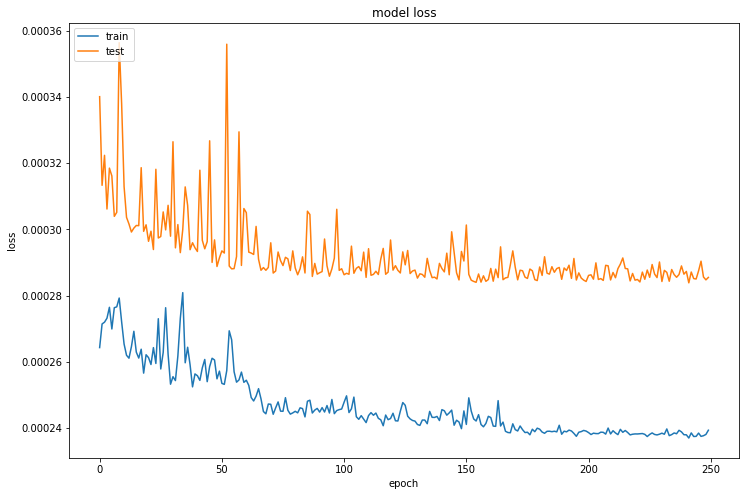

In [109]:
#### Plot do erro variando ao longo do treinamento 
fig=plt.figure(figsize=(12,8))
# summarize history for loss
plt.plot(history.history['loss'][50:])
plt.plot(history.history['val_loss'][50:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [110]:
#### Iremos fazer nesse bloco a previsão do conjunto de dados teste ,ou seja a rede funcionadno no dia dia 
### e logo em seguida desnormlizaremos os dados 
pred=model.predict(x_test)
pred_unorm=[]
for i in range(len(pred)):
    pred_unorm.append([unorm_tanh(pred[i,0]/10.,min_mean,min_std),
                       unorm_tanh(pred[i,1]/10.,max_mean,max_std)])
pred_unorm=np.array(pred_unorm)

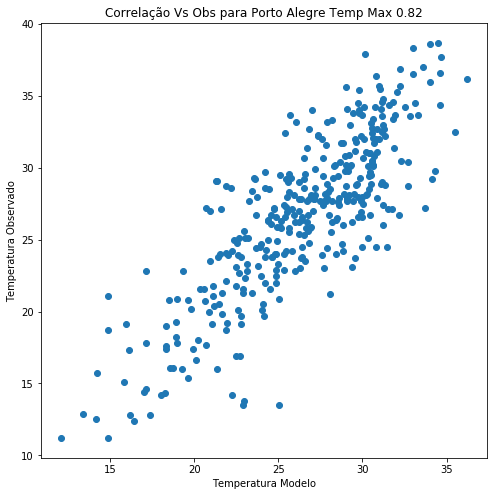

In [111]:
### iremos analizar a correlaçao do dodos e espalhamento 
### e a correlçao do dados cor > 0.8 relação muito forte entre variaveis 
fig=plt.figure(figsize=(8,8))
plt.ylabel('Temperatura Observado')
plt.xlabel('Temperatura Modelo')
cor=np.corrcoef(pred_unorm[:,1],Y_test[:,1])[0]
plt.title('Correlação Vs Obs para Porto Alegre Temp Max %0.2f'%cor[-1])
plt.plot(pred_unorm[:,1],Y_test[:,1],'o')
plt.show()

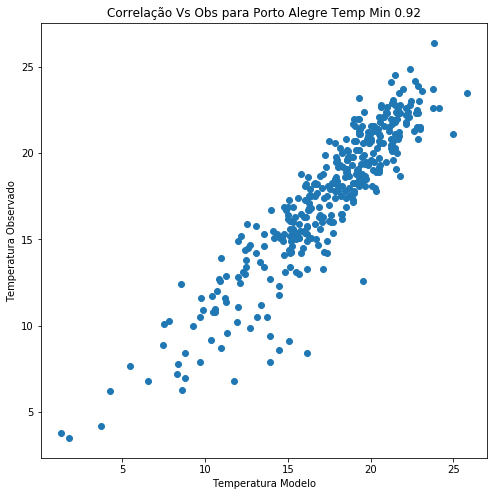

In [112]:
### iremos analizar a correlaçao do dodos e espalhamento da temp Minima
### e a correlçao do dados cor > 0.8 relação muito forte entre variaveis 
fig=plt.figure(figsize=(8,8))
plt.ylabel('Temperatura Observado')
plt.xlabel('Temperatura Modelo')
cor=np.corrcoef(pred_unorm[:,0],Y_test[:,0])[0]
plt.title('Correlação Vs Obs para Porto Alegre Temp Min %0.2f'%cor[-1])
plt.plot(pred_unorm[:,0],Y_test[:,0],'o')
plt.show()

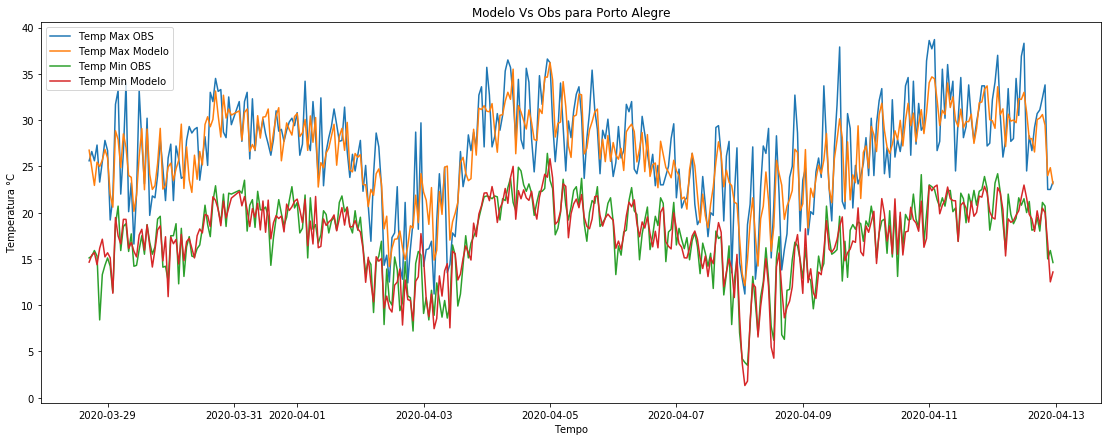

In [113]:
### Plotar no ultimo o ano o desempenho da rede neural e o observado
fig=plt.figure(figsize=(19,7))
plt.plot(x_dates,Y_test[:,1])
plt.plot(x_dates,pred_unorm[:,1])
plt.plot(x_dates,Y_test[:,0])
plt.plot(x_dates,pred_unorm[:,0])
plt.legend(['Temp Max OBS', 'Temp Max Modelo','Temp Min OBS','Temp Min Modelo'], loc='upper left')
plt.ylabel('Temperatura °C')
plt.xlabel('Tempo')
plt.title('Modelo Vs Obs para Porto Alegre')
plt.show()

In [114]:
##### analizaremos o erro medio qradatico absoluto 
x2=0
ab=0
for i in range(len(pred_unorm[:,1])):
    x2+=(pred_unorm[i,1]-Y_test[i,1])**2
    ab+=abs(pred_unorm[i,1]-Y_test[i,1])
emq=x2/len(pred_unorm)
eab=ab/len(pred_unorm)
print('Erro Médio Quadratico Temp Max. = %0.4f'%emq)
print('Erro Medio Absoluto Temp Max. = %0.4f °C'% eab)
print('Desvio padrão dos dados Temp Max. : %0.4f'%np.std(Y_test[:,1]))

Erro Médio Quadratico Temp Max. = 10.0867
Erro Medio Absoluto Temp Max. = 2.5030 °C
Desvio padrão dos dados Temp Max. : 5.5829


In [115]:
##### analizaremos o erro medio qradatico absoluto 
x2=0
ab=0
for i in range(len(pred_unorm[:,0])):
    x2+=(pred_unorm[i,0]-Y_test[i,0])**2
    ab+=abs(pred_unorm[i,0]-Y_test[i,0])
emq=x2/len(pred_unorm)
eab=ab/len(pred_unorm)
print('Erro Médio Quadratico Temp Min. = %0.4f'%emq)
print('Erro Medio Absoluto Temp Min. = %0.4f °C'% eab)
print('Desvio padrão dos dados Temp Min. : %0.4f'%np.std(Y_test[:,1]))

Erro Médio Quadratico Temp Min. = 2.8645
Erro Medio Absoluto Temp Min. = 1.3111 °C
Desvio padrão dos dados Temp Min. : 5.5829
